In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

Un valor atípico es una observación diferente a las otras observaciones. Es raro, distinto o no encaja de alguna manera. También se le llama anomalías.
Tipo de outliers:
* Univariate: solo tenemos en cuenta una variable.
* Multivariate: tenemos en cuenta n-variables.


In [3]:
# Detección de outliers univariable

# cargamos el dataset de heart-disease https://archive.ics.uci.edu/ml/datasets/Heart+Disease
df_1 = pd.read_csv("Heart.csv")
df_1.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [4]:
# ejecutamos los comandos básicos para un análisis exploratorio de los datos
df_1.isnull().sum()

Unnamed: 0    0
Age           0
Sex           0
ChestPain     0
RestBP        0
Chol          0
Fbs           0
RestECG       0
MaxHR         0
ExAng         0
Oldpeak       0
Slope         0
Ca            4
Thal          2
AHD           0
dtype: int64

In [5]:
df_1.describe()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000
mean,152.000000,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241
std,87.612784,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,76.500000,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,152.000000,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,227.500000,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,303.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


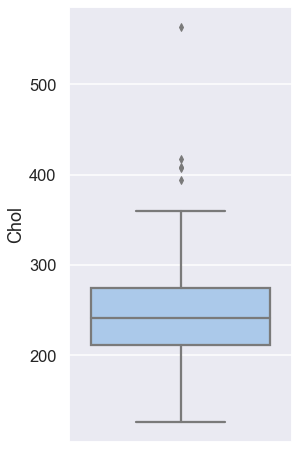

In [7]:
# Consideremos el colesterol en sangre en una columna de mg / dl, es decir, "chol" para nuestro análisis.
# Hacemos un análisis visual de los valores con un diagrama de bigotes
plt.figure(figsize = (4,8))
sns.boxplot(y = df_1.Chol)

In [8]:
# Método intercuartil
# usamos el cálculo del rango intercuartil para detectar los outliers. en este caso los outliers se definen como 
# si están por debajo del (Q1 − 1.5xIQR) o por encima (Q3 + 1.5x IQR)

def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # IQR
    iqr = q75 - q25
    # outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('IQR',iqr)
    print('El limite inferior es', lower)
    print('El limite superior es', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Número total de outliers detectados', df1.shape[0]+ df2.shape[0])

In [9]:
out_iqr(df_1,'Chol')

IQR 64.0
El limite inferior es 115.0
El limite superior es 371.0
Número total de outliers detectados 5


In [10]:
# Una posible solución en este caso para limpiar el dataset es eliminar dichos valores.

# Método de la desviación estándar
desviación estándar: cuánto se separan los puntos de datos individuales de la media. En estadística, si una distribución de datos es aproximadamente normal, aproximadamente el 68% de los valores de los datos se encuentran dentro de una desviación estándar de la media y aproximadamente el 95% están dentro de dos desviaciones estándar, y aproximadamente el 99,7% se encuentran dentro de tres desviaciones estándar.

In [11]:
df_2 = pd.read_csv("StudentsPerformance.csv") # http://roycekimmons.com/tools/generated_data/exams
df_2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


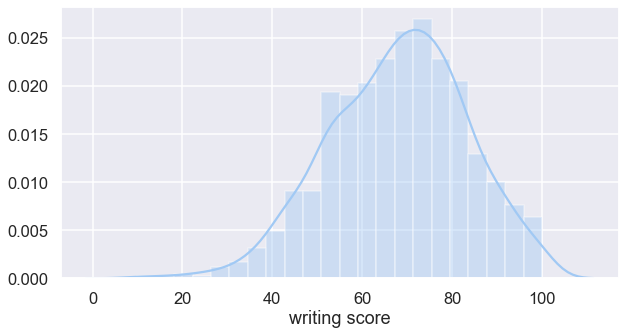

In [12]:
# vamos a observar la variable writing score.
plt.figure(figsize = (10,5))
sns.distplot(df_2['writing score'])

In [13]:
# parece que está desviado por la izquierda, habrá que analizar qué pasa.
def out_std(df, column):
    global lower,upper
    # calculate the mean and standard deviation of the data frame
    data_mean, data_std = df[column].mean(), df[column].std()
    # calculate the cutoff value
    cut_off = data_std * 3
    # calculate the lower and upper bound value
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print('El límite inferior es', lower)
    print('El limite superior es', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Número total de outliers', df1.shape[0]+ df2.shape[0])

In [14]:
out_std(df_2,'writing score')


El límite inferior es 22.46702896739105
El limite superior es 113.64097103260895
Número total de outliers 4


In [ ]:
# Al igual que en el caso anterior, una posible solución en esta situación es eliminar esos valores.

# Isolation forest
Es un algoritmo para detectar valores atípicos. Divide los datos utilizando un conjunto de árboles y proporciona una puntuación de anomalía que observa qué tan aislado está el punto en la estructura encontrada. La puntuación de anomalía se utiliza para diferenciar los valores atípicos de las observaciones normales.

Un concepto importante en este método es el número de aislamiento. El número de aislamiento es el número de divisiones necesarias para aislar un punto de datos. Este número de divisiones se determina siguiendo estos pasos:

* Se selecciona aleatoriamente un punto “a” a aislar.
* Se selecciona un punto de datos aleatorio “b” que esté entre el valor mínimo y máximo y diferente de “a”.
* Si el valor de "b" es menor que el valor de "a", el valor de "b" se convierte en el nuevo límite inferior.
* Si el valor de "b" es mayor que el valor de "a", el valor de "b" se convierte en el nuevo límite superior.
* Este procedimiento se repite siempre que haya puntos de datos distintos de "a" entre el límite superior y el inferior.

Se requiere menos divisiones para aislar un valor atípico que para aislar un valor no atípico, es decir, un valor atípico tiene un número de aislamiento más bajo en comparación con un punto no atípico. Por lo tanto, un punto de datos se define como un valor atípico si su número de aislamiento es inferior al umbral. El umbral se define en función del porcentaje estimado de valores atípicos en los datos, que es el punto de partida de este algoritmo de detección de valores atípicos.

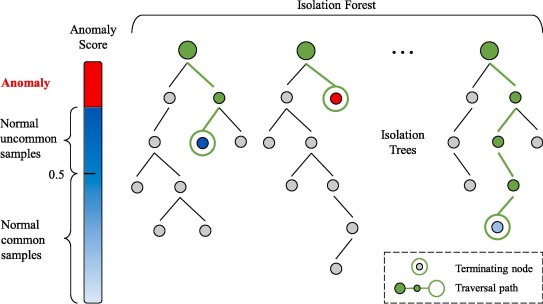

In [16]:
Image(filename='isolationforest.jpg')

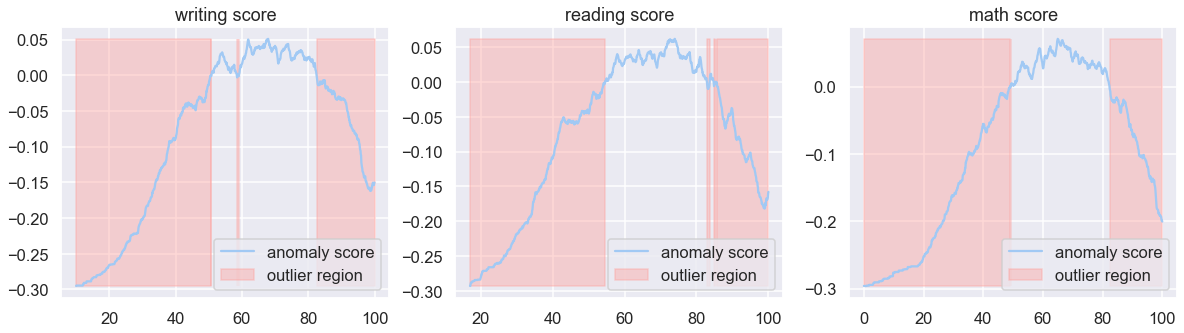

In [17]:
from sklearn.ensemble import IsolationForest
#The required columns
cols = ['writing score','reading score','math score']
#Plotting the sub plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df_2[column].values.reshape(-1,1))

    xx = np.linspace(df_2[column].min(), df_2[column].max(), len(df_2)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

# Multivariate outliers

## Local Outlier Factor Method(LOF)

LOF utiliza la detección de valores atípicos basada en la densidad para identificar valores atípicos locales, puntos que son valores atípicos con respecto a su vecindario local, en lugar de con respecto a la distribución global de datos. 

Cuanto mayor sea el valor de LOF para una observación, más anómala será la observación.

In [16]:
# En el dataset de enfermedad cardíaca vamos a observar las variables edad y colesterol

clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
X = df_1[['age','chol']].values
y_pred = clf.fit_predict(X)

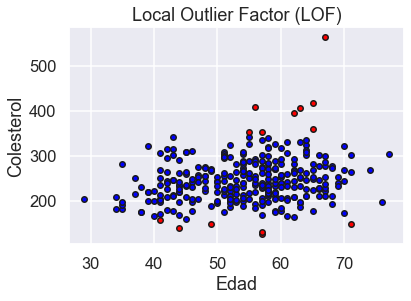

In [17]:
in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
plt.xlabel('Edad');
plt.ylabel('Colesterol');
plt.show()